# Rift margin 



        


In [1]:
import matplotlib.pyplot as plt
import UWGeodynamics as GEO
import underworld as uw
import underworld.function as fn
from UWGeodynamics.surfaceProcesses import SedimentationThreshold
import numpy as np
import scipy
import os.path
from mpi4py import MPI
import argparse
import glucifer # pour faire les figures. 
                # Si tu ne te commentes pas avant de l'envoyer sur le cluster, ce n'est pas grave: 
                # il va te dire qu'il ne le trouve pas. Tu auras une erreur mais le code tournera quand meme.

loaded rc file /usr/local/lib/python3.5/dist-packages/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
# Just to be sure about the version you are using

GEO.__version__

'2.8.1-dev-efa530e(development)'

In [3]:
def setup_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--res_scale", action='store', default = 1.)
    parser.add_argument("--total_vel", action="store", required = True)
    #parser.add_argument("--time_to_stop", action="store", default = -1.)
    parser.add_argument("--gap_to_stop_sedi", action="store", required = True)
    parser.add_argument("--total_time", action="store", required = True)
    parser.add_argument("--name", action="store", required = True)

    return parser.parse_args()

## <span style="color:brown"> Scaling - Resolution </span>

In [4]:

u = GEO.UnitRegistry


##### Characteristic values of the system

half_rate     = 1. * u.centimeter / u.year # What is it?
model_length  = 360e3 * u.meter # 512 would avoid the boundaries effects
model_height  = 200e3 * u.kilometer
refViscosity = 1e21 * u.pascal * u.second
surfaceTemp   = 293.15 * u.degK
baseModelTemp = 1623.15 * u.degK
bodyforce     = 3150. * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2 # ckeck publi schellart

KL = model_length # Characteristic length
Kt = KL / half_rate # Characteristic time
KM = bodyforce * KL**2 * Kt**2 # Characteristic mass
KT = (baseModelTemp - surfaceTemp) # Characteristic temperature

GEO.scaling_coefficients["[length]"]      = KL
GEO.scaling_coefficients["[time]"]        = Kt
GEO.scaling_coefficients["[mass]"]        = KM
GEO.scaling_coefficients["[temperature]"] = KT

resolution = (128, 64)
Model = GEO.Model(elementRes = resolution, 
                  minCoord = (0. * u.kilometer, -170. * u.kilometer), 
                  maxCoord = (360. * u.kilometer, 30. * u.kilometer)) 

Model.minViscosity  = 1e18 * u.pascal * u.second
Model.maxViscosity  = 5e23 * u.pascal * u.second
Model.stressLimiter = 300. * u.megapascal
Model.diffusivity   = 1e-6 * u.metre**2 / u.second
Model.capacity      = 1000. * u.joule / (u.kelvin * u.kilogram)

Model.outputDir="outputs2"


## <span style="color:brown"> Computational domain - Materials </span>

In [5]:
#interfaceX = 600 * u.kilometre
interfaceX = 180 * u.kilometre
UpperCrustHL = -30 * u.kilometre
UpperCrustHR = -22 * u.kilometre
CrustHL = -44 * u.kilometre
CrustHR = -34 * u.kilometre
LithL = -150 * u.kilometre
LithR = -130 * u.kilometre

In [6]:

air               = Model.add_material(name="Air", shape=GEO.shapes.Layer(top=30.0 * u.kilometer, bottom=10.0 * u.kilometer))
stickyAir         = Model.add_material(name="StickyAir", shape=GEO.shapes.Layer(top=air.bottom, bottom= 0.0 * u.kilometer))
sediment = Model.add_material(name="Sediment")


# Right Box Definitions. Ici tu n'as pas besoin de faire des boxes mais des couches. Tu surimposera les boxes de droite apres: Ca t evite d'avoir des espaces entre les boxes de droite et de gauche.

uppercrust_Geo_R = GEO.shapes.Layer(top=stickyAir.bottom, bottom=-22 * u.kilometer)
uppercrust_R = Model.add_material(name="Uppercrust_R", shape=uppercrust_Geo_R)

lowercrust_Geo_R = GEO.shapes.Layer(top=-22 * u.kilometer, bottom=-34 * u.kilometer)
lowercrust_R = Model.add_material(name="Lowercrust_R", shape=lowercrust_Geo_R)

mantleLithosphere_Geo_R = GEO.shapes.Layer(top=-34 * u.kilometer, bottom=-130 * u.kilometer)
mantleLithosphere_R = Model.add_material(name="MantleLithosphere_R", shape=mantleLithosphere_Geo_R)

mantleAsthenosphere = GEO.shapes.Layer(top=-130 * u.kilometer, bottom=Model.bottom)
mantleAsthenosphere = Model.add_material(name="MantleAsthenosphere", shape=mantleAsthenosphere)



# Left Box Definitions

uppercrust_Geo_L = GEO.shapes.Box(top=0.* u.kilometer, bottom=-30 * u.kilometer, minX=0.*u.kilometer, maxX=interfaceX)
uppercrust_L = Model.add_material(name="Uppercrust_L", shape=uppercrust_Geo_L)

lowercrust_Geo_L = GEO.shapes.Box(top=-30 * u.kilometer, bottom=-34 * u.kilometer, minX=0.*u.kilometer, maxX=interfaceX)
lowercrust_L = Model.add_material(name="Lowercrust_L", shape=lowercrust_Geo_L)

mantleLithosphere_Geo_L = GEO.shapes.Box(top=-34 * u.kilometer, bottom=-150 * u.kilometer, minX=0.*u.kilometer, maxX=interfaceX)
mantleLithosphere_L = Model.add_material(name="MantleLithosphere_L", shape=mantleLithosphere_Geo_L)

 
Model.swarm.particleEscape = True

In [7]:
# Here you verify that there is no empty part

np.unique(Model.materialField.data)
np.where(Model.materialField == 0 )

(array([], dtype=int64),)


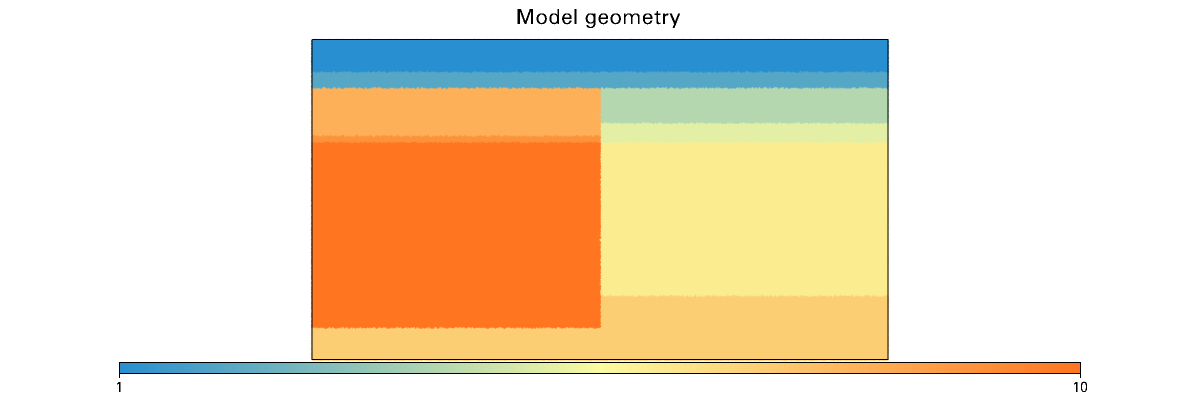

In [8]:
## Plot the Material field

# Fig = glucifer.Figure()
# Fig.Points(Model.swarm, Model.materialField, cullface=False, opacity=1.,)
# viewer = Fig.viewer(resolution=(640,480))
# viewer = Fig.viewer(axis=True)
# viewer = Fig.viewer(rulers=False)
# viewer = Fig.viewer(quality=3)
# viewer.rotatex(-0)
# viewer.rotatey(-0)
# viewer.rotatez(-0)
# viewer.window()

## or

Fig = glucifer.Figure(figsize=(1200,400), title="Model geometry", quality=2)
Fig.Points(Model.swarm, Model.materialField, fn_size=3.)
Fig.show()

In [9]:
air.diffusivity = 1.0e-5 * u.metre**2 / u.second
stickyAir.diffusivity = 1.0e-5 * u.metre**2 / u.second

air.capacity = 100. * u.joule / (u.kelvin * u.kilogram)
stickyAir.capacity = 100. * u.joule / (u.kelvin * u.kilogram)


### Density


air.density = 0.1 * u.kilogram / u.metre**3
stickyAir.density = 0.1 * u.kilogram / u.metre**3
sediment.density = 2200. * u.kilogram / u.metre**3


uppercrust_L.density = GEO.LinearDensity(2620. * u.kilogram / u.metre**3)
uppercrust_R.density = GEO.LinearDensity(2620. * u.kilogram / u.metre**3)

lowercrust_L.density = GEO.LinearDensity(2820. * u.kilogram / u.metre**3)
lowercrust_R.density = GEO.LinearDensity(2820. * u.kilogram / u.metre**3)

mantleLithosphere_L.density = GEO.LinearDensity(3370. * u.kilogram / u.metre**3)
mantleLithosphere_R.density = GEO.LinearDensity(3370. * u.kilogram / u.metre**3)

mantleAsthenosphere.density = GEO.LinearDensity(3395. * u.kilogram / u.metre**3)


### Radiogenic Heat Production

sediment.radiogenicHeatProd = 0.9 * u.microwatt / u.meter**3

uppercrust_L.radiogenicHeatProd = 0.8 * u.microwatt / u.meter**3
uppercrust_R.radiogenicHeatProd = 0.8 * u.microwatt / u.meter**3

lowercrust_L.radiogenicHeatProd = 0.5 * u.microwatt / u.meter**3
lowercrust_R.radiogenicHeatProd = 0.5 * u.microwatt / u.meter**3

mantleLithosphere_L.radiogenicHeatProd = 0.00154 * u.microwatt / u.meter**3
mantleLithosphere_R.radiogenicHeatProd = 0.00154 * u.microwatt / u.meter**3

mantleAsthenosphere.radiogenicHeatProd = 0.00154  * u.microwatt / u.meter**3



### Elastic Properties


eta     = 5e23 * u.pascal * u.second # Viscosity
mu      = 100e9 * u.pascal # Shear Modulus

alpha = eta / mu         # Maxwell relaxation time
dt_e    = 20e3 * u.year  # Load relaxation time
eta_eff = ( eta * dt_e ) / (alpha + dt_e)  # effective viscosity

yieldStrength = 12e6 * (u.kilogram * u.meter**-1 * u.second**-2)

minVisc = 1e19 * (u.kilogram * u.meter**-1 * u.second**-2) * u.second
maxVisc = 1e24  * (u.kilogram * u.meter**-1 * u.second**-2) * u.second

density = 2700 * u.kilogram / u.metre**3
gravity = 9.81 * u.metre / u.second**2

shearVelocity = 0.5 * u.centimetre / u.year

print('Maxwell relaxation time = ', alpha.to(u.years))
print("Observation time        = ", dt_e.to(u.year), dt_e)
print("effective viscosity     = ", eta_eff.to(u.pascal * u.second))


uppercrust_L.elasticity           = GEO.Elasticity(shear_modulus=100.*u.gigapascal, observation_time=20000. * u.year)
uppercrust_R.elasticity           = GEO.Elasticity(shear_modulus=100.*u.gigapascal, observation_time=20000. * u.year)
lowercrust_L.elasticity           = GEO.Elasticity(shear_modulus=100.*u.gigapascal, observation_time=20000. * u.year)
lowercrust_R.elasticity           = GEO.Elasticity(shear_modulus=100.*u.gigapascal, observation_time=20000. * u.year)
mantleLithosphere_L.elasticity    = GEO.Elasticity(shear_modulus=100.*u.gigapascal, observation_time=20000. * u.year)
mantleLithosphere_R.elasticity    = GEO.Elasticity(shear_modulus=100.*u.gigapascal, observation_time=20000. * u.year)


Maxwell relaxation time =  158443.82320409245 year
Observation time        =  20000.0 year 20000.0 year
effective viscosity     =  5.6040045659426654e+22 pascal * second


In [10]:
### Viscous Rheologies


rh = GEO.ViscousCreepRegistry()



air.viscosity                = 1e18 * u.pascal * u.second
stickyAir.viscosity          = 1e18 * u.pascal * u.second
sediment.viscosity             = rh.Wet_Quartz_Dislocation_Gleason_and_Tullis_1995

uppercrust_L.viscosity         = rh.Wet_Quartz_Dislocation_Gleason_and_Tullis_1995
uppercrust_R.viscosity         = rh.Wet_Quartz_Dislocation_Gleason_and_Tullis_1995

lowercrust_L.viscosity         = rh.Wet_Anorthite_Dislocation_Ribacki_et_al_2000
lowercrust_R.viscosity         = rh.Wet_Anorthite_Dislocation_Ribacki_et_al_2000

mantleLithosphere_L.viscosity  = rh.Wet_Olivine_Dislocation_Hirth_and_Kohlstedt_2003
mantleLithosphere_R.viscosity  = rh.Wet_Olivine_Dislocation_Hirth_and_Kohlstedt_2003

mantleAsthenosphere.viscosity  = rh.Wet_Olivine_Dislocation_Hirth_and_Kohlstedt_2003

sediment.minViscosity   = 1e18 * u.pascal * u.second
sediment.maxViscosity   = 1e23 * u.pascal * u.second
uppercrust_L.minViscosity = 1e18 * u.pascal * u.second
uppercrust_L.maxViscosity = 1e23 * u.pascal * u.second
uppercrust_R.minViscosity = 1e18 * u.pascal * u.second
uppercrust_R.maxViscosity = 1e23 * u.pascal * u.second
lowercrust_L.minViscosity = 1e18 * u.pascal * u.second
lowercrust_L.maxViscosity = 1e23 * u.pascal * u.second
lowercrust_R.minViscosity = 1e18 * u.pascal * u.second
lowercrust_R.maxViscosity = 1e23 * u.pascal * u.second
mantleLithosphere_L.minViscosity   = 1e19 * u.pascal * u.second
mantleLithosphere_L.maxViscosity   = 1e23 * u.pascal * u.second
mantleLithosphere_R.minViscosity   = 1e19 * u.pascal * u.second
mantleLithosphere_R.maxViscosity   = 1e23 * u.pascal * u.second
mantleAsthenosphere.minViscosity   = 1e19 * u.pascal * u.second
mantleAsthenosphere.maxViscosity   = 1e23 * u.pascal * u.second

#Model.viscosity = 1e20 * u.pascal * u.second


# ## Plasticities

pl = GEO.PlasticityRegistry()


uppercrust_R.plasticity                        = pl.Rey_and_Muller_2010_UpperCrust
uppercrust_R.plasticity.frictionCoefficient    = 0.55
uppercrust_R.plasticity.frictionAfterSoftening = 0.055


sediment.plasticity             = uppercrust_R.plasticity 
uppercrust_L.plasticity         = uppercrust_R.plasticity 




lowercrust_L.plasticity         = pl.Rey_et_al_2014_LowerCrust
lowercrust_L.plasticity         = GEO.DruckerPrager(
                                  name="Upper Crust Plasticity",
                                  cohesion=10. * u.megapascal,
                                  cohesionAfterSoftening=2.0 * u.megapascal,
                                  frictionCoefficient=0.577,
                                  frictionAfterSoftening=0.01154,
                                  epsilon1=0.0, epsilon2=0.20)


lowercrust_R.plasticity         = lowercrust_L.plasticity

mantleLithosphere_L.plasticity  = pl.Rey_et_al_2014_LithosphericMantle
mantleLithosphere_R.plasticity  = pl.Rey_et_al_2014_LithosphericMantle

mantleAsthenosphere.plasticity  = pl.Rey_et_al_2014_LithosphericMantle

uppercrust_L.stressLimiter = 150 * u.megapascals
uppercrust_R.stressLimiter = 150 * u.megapascals
lowercrust_L.stressLimiter = 150 * u.megapascals
lowercrust_R.stressLimiter = 150 * u.megapascals
mantleLithosphere_L.stressLimiter = 300 * u.megapascals
mantleLithosphere_R.stressLimiter = 300 * u.megapascals
mantleAsthenosphere.stressLimiter = 300 * u.megapascals



In [11]:
viscosity_scaling = GEO.Dimensionalize(1., u.Pa * u.sec)

/usr/local/lib/python3.5/dist-packages/UWGeodynamics/__init__.py:83: UserWarning: 'Dimensionalize' has been changed to 'dimensionalise', please use the later
  warnings.warn("""'Dimensionalize' has been changed to 'dimensionalise', please use the later""")


In [12]:
#rh.Wet_Olivine_Dislocation_Hirth_and_Kohlstedt_2003

In [13]:
#pl.Rey_and_Muller_2010_UpperCrust

## <span style="color:brown"> Partial Melting </span>

In this experiment (parameters from https://github.com/LukeMondy/Continental_Rifting), the viscosity decreases linearly by 3 orders of magnitude when the melt fraction increases from 15 to 30%. When the melt fraction is 15%, the viscosity of the melted crust is that of the non-melted surrounding; when the melt fraction is 30%, its viscosity is a thousand times lower than in surrounding material. Rosenberg and Handy (2005) showed that significant weakening occurs at 7% melt fraction.

In [14]:
## Partial melting

# Note: notice the meltExpansion is set to 0. Since we don't have any melt transport (all melt is held in place)
#       we wouldn't then expect any density change.
#       Patrice respectflly disagre with the above statement. The density decrease is due to the lower density of melt, so
#       even when melt stay in the source, it impacts of the density. 


# Solidus
solidii = GEO.SolidusRegistry()
crust_solidus = solidii.Crustal_Solidus
mantle_solidus = solidii.Mantle_Solidus

#Liquidus
liquidii = GEO.LiquidusRegistry()
crust_liquidus = liquidii.Crustal_Liquidus
mantle_liquidus = liquidii.Mantle_Liquidus


uppercrust_L.stressLimiter = 150 * u.megapascals
uppercrust_R.stressLimiter = 150 * u.megapascals
lowercrust_L.stressLimiter = 150 * u.megapascals
lowercrust_R.stressLimiter = 150 * u.megapascals
mantleLithosphere_L.stressLimiter = 300 * u.megapascals
mantleLithosphere_R.stressLimiter = 300 * u.megapascals
mantleAsthenosphere.stressLimiter = 300 * u.megapascals




sediment.add_melt_modifier(crust_solidus, crust_liquidus, 
                         latentHeatFusion=250.0 * u.kilojoules / u.kilogram / u.kelvin,
                         meltFraction=0.,
                         meltFractionLimit=0.3,
                         meltExpansion=0.0, 
                         viscosityChangeX1 = 0.15,
                         viscosityChangeX2 = 0.30,
                         viscosityChange = 1e-3
                        )
uppercrust_L.add_melt_modifier(crust_solidus, crust_liquidus, 
                         latentHeatFusion=250.0 * u.kilojoules / u.kilogram / u.kelvin,
                         meltFraction=0.,
                         meltFractionLimit=0.3,
                         meltExpansion=0.0, 
                         viscosityChangeX1 = 0.15,
                         viscosityChangeX2 = 0.30,
                         viscosityChange = 1e-3
                        )
uppercrust_R.add_melt_modifier(crust_solidus, crust_liquidus, 
                         latentHeatFusion=250.0 * u.kilojoules / u.kilogram / u.kelvin,
                         meltFraction=0.,
                         meltFractionLimit=0.3,
                         meltExpansion=0.0, 
                         viscosityChangeX1 = 0.15,
                         viscosityChangeX2 = 0.30,
                         viscosityChange = 1e-3
                        )
lowercrust_L.add_melt_modifier(crust_solidus, crust_liquidus, 
                         latentHeatFusion=250.0 * u.kilojoules / u.kilogram / u.kelvin,
                         meltFraction=0.,
                         meltFractionLimit=0.3,
                         meltExpansion=0.13, 
                         viscosityChangeX1 = 0.15,
                         viscosityChangeX2 = 0.30,
                         viscosityChange = 1e-3
                        ) 
lowercrust_R.add_melt_modifier(crust_solidus, crust_liquidus, 
                         latentHeatFusion=250.0 * u.kilojoules / u.kilogram / u.kelvin,
                         meltFraction=0.,
                         meltFractionLimit=0.3,
                         meltExpansion=0.13, 
                         viscosityChangeX1 = 0.15,
                         viscosityChangeX2 = 0.30,
                         viscosityChange = 1e-3
                        ) 
mantleLithosphere_L.add_melt_modifier(mantle_solidus, mantle_liquidus, 
                         latentHeatFusion=450.0 * u.kilojoules / u.kilogram / u.kelvin,
                         meltFraction=0.,
                         meltFractionLimit=0.05,
                         meltExpansion=0.13, 
                         viscosityChangeX1 = 0.00,
                         viscosityChangeX2 = 0.03,
                         viscosityChange = 1e-3
                        ) 
mantleLithosphere_R.add_melt_modifier(mantle_solidus, mantle_liquidus, 
                         latentHeatFusion=450.0 * u.kilojoules / u.kilogram / u.kelvin,
                         meltFraction=0.,
                         meltFractionLimit=0.05,
                         meltExpansion=0.13, 
                         viscosityChangeX1 = 0.00,
                         viscosityChangeX2 = 0.03,
                         viscosityChange = 1e-3
                        ) 
mantleAsthenosphere.add_melt_modifier(mantle_solidus, mantle_liquidus, 
                         latentHeatFusion=450.0 * u.kilojoules / u.kilogram / u.kelvin,
                         meltFraction=0.,
                         meltFractionLimit=0.05,
                         meltExpansion=0.13, 
                         viscosityChangeX1 = 0.00,
                         viscosityChangeX2 = 0.03,
                         viscosityChange = 1e-3
                        ) 

## <span style="color:brown"> Add Tracking Passive Tracers - Strain Ellipses </span>

In [15]:
# # Add Passive Tracers

x = np.linspace(Model.minCoord[0], Model.maxCoord[0], resolution[0]/2) * u.kilometer
y = 0. * u.kilometer

surface_tracers = Model.add_passive_tracers(name="Surface", vertices=[x, y])
moho_tracers = Model.add_passive_tracers(name="Moho", vertices=[x, y-40. * u.kilometer])

x_c, y_c = GEO.circles_grid(radius=2.0*u.kilometer, 
                    minCoord=[Model.minCoord[0], -40.0*u.kilometer], 
                    maxCoord=[Model.maxCoord[0], 0.*u.kilometer])
circles_c = Model.add_passive_tracers(name="FSE_Crust", vertices=[x_c, y_c])


x_m, y_m = GEO.circles_grid(radius=2.0*u.kilometer, 
                    minCoord=[Model.minCoord[0], -90.0*u.kilometer], 
                    maxCoord=[Model.maxCoord[0], -40.0*u.kilometer])
circles_m = Model.add_passive_tracers(name="FSE_Mantle", vertices=[x_m, y_m])

x1 = 0. * u.kilometer
y1 = -40. * u.kilometer
pt1_tracer = Model.add_passive_tracers(name="Pt1", vertices=[x1, y1])

pt1_tracer.add_tracked_field(Model.pressureField,
                              name="Pt1_Press",
                              units=u.megapascal,
                              dataType="float")
pt1_tracer.add_tracked_field(Model.strainRateField,
                              name="Pt1_StrainRate",
                              units=1.0/u.sec,
                              dataType="float")

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)



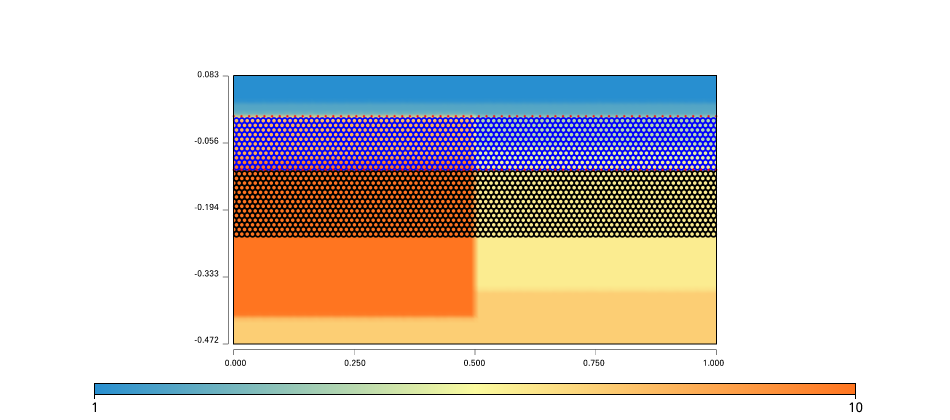

In [16]:
## Plot the tracers and ellipsis: That's Patrice's method to visualize the deformation

Fig = glucifer.Figure(figsize=(950,420), margin=0.08, 
                       rulers=True, 
                       rulerticks=5,
                       rulerwidth=0.5,
                       fontscale=0.7)
Fig.append(glucifer.objects.Surface(Model.mesh, Model.projMaterialField))
Fig.append(glucifer.objects.Points(surface_tracers, colour='red', pointSize=3.0))
Fig.append(glucifer.objects.Points(moho_tracers,  colour='red', pointSize=3.0))
Fig.append(glucifer.objects.Points(circles_c, colour='blue', pointSize=2.0))
Fig.append(glucifer.objects.Points(circles_m,  colour='black', pointSize=2.0))
Fig.show()

## <span style="color:brown"> Add Initial Damage zone </span>

The model are a bit more realisitic if we allocate a plastic damage randomly choosen between 0 and a maximum value (maxDamage) to each particle. Here the maximum damage follows a gaussian function imposing a peak at the center of the model. It allows a "more realistic" break up. It induces that the initial deformation will develop in the crust. We can avoid that using a "notche", which is a material anomaly at the base of the crust. 

In [17]:
## Simple case

def gaussian(xx, centre, width):
    return ( np.exp( -(xx - centre)**2 / width ))

maxDamage = 0.2 # tu peux le modifier pour changer le damage initial de ta croute. 
centre = (GEO.nd(180. * u.kilometer), GEO.nd(-20. * u.kilometer)) # centreé sur 180 en X et -20 km de prof. 
width = GEO.nd(5. * u.kilometer)  # this gives a normal distribution
                                  # from about -100 km to 100 km

Model.plasticStrain.data[:] = maxDamage * np.random.rand(*Model.plasticStrain.data.shape[:])
Model.plasticStrain.data[:,0] *= gaussian(Model.swarm.particleCoordinates.data[:,0], centre[0], width)
Model.plasticStrain.data[:,0] *= gaussian(Model.swarm.particleCoordinates.data[:,1], centre[1], width*100)

# The following lines make the random damage only apply to the crust
noncrust_mask = Model.swarm.particleCoordinates.data[:,1] <= GEO.nd(-40 * u.kilometer)
air_mask = Model.swarm.particleCoordinates.data[:,1] > GEO.nd(0 * u.kilometer)

Model.plasticStrain.data[noncrust_mask] = 0.0
Model.plasticStrain.data[air_mask] = 0.0


In [18]:
## If you prefer a most complex initial damage state, You can still add different gaussian fonctions (I think that's what Patrice is doing):

# def gaussian(xx, centre, width):
#     return ( np.sin(np.exp( -(xx - centre)**2/width)))

# maxDamage = 0.02
# centre = (GEO.nd(0. * u.kilometer), GEO.nd(-15. * u.kilometer))
# width = GEO.nd(1. * u.kilometer)  # this gives a normal distribution
# ywavelength = GEO.nd(0.25 * u.kilometer)

# Model.plasticStrain.data[:] = maxDamage * np.random.rand(*Model.plasticStrain.data.shape[:])
# Model.plasticStrain.data[:,0] *= gaussian(Model.swarm.particleCoordinates.data[:,0], centre[0], width/2)+gaussian(Model.swarm.particleCoordinates.data[:,0], centre[0], width/2)+gaussian(Model.swarm.particleCoordinates.data[:,0], centre[0]-0.2, width)+gaussian(Model.swarm.particleCoordinates.data[:,0], centre[0]+0.2, width)+gaussian(Model.swarm.particleCoordinates.data[:,0], centre[0]-0.1, width*2)+gaussian(Model.swarm.particleCoordinates.data[:,0], centre[0]+0.1, width*2)
# Model.plasticStrain.data[:,0] *= gaussian(Model.swarm.particleCoordinates.data[:,1], centre[1], ywavelength)

# # The following lines make the random damage only apply to the crust
# noncrust_mask = Model.swarm.particleCoordinates.data[:,1] <= GEO.nd(-40 * u.kilometer)
# air_mask = Model.swarm.particleCoordinates.data[:,1] > GEO.nd(0 * u.kilometer)

# Model.plasticStrain.data[noncrust_mask] = 0.0
# Model.plasticStrain.data[air_mask] = 0.0



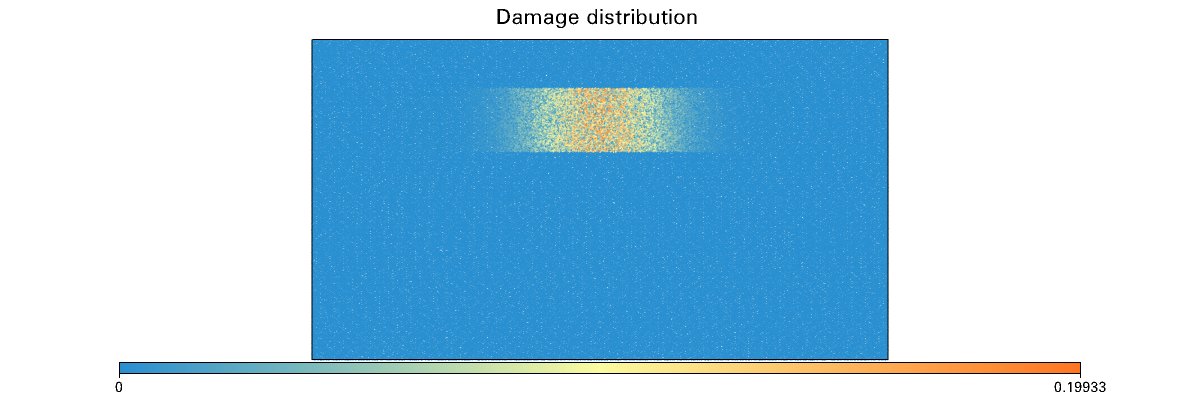

In [19]:
## Plot the initial damage:

Fig = glucifer.Figure(figsize=(1200,400), title="Damage distribution", quality=2)
Fig.Points(Model.swarm, Model.plasticStrain, fn_size=2.0)
Fig.show()

In [20]:
def multinomial_normal_fusion(x, params):
    params = [centre, sigma, maxDamage, width]
    par = np.reshape(params, (len(params) / 4, 4))
    n = len(par)
    curve = np.zeros(len(x))
    for i in range(n):
        centre, sigma, maxDamage, width = par[i]
        xi = np.searchsorted(x, centre)
        curve[0:xi] += maxDamage * scipy.stats.norm.pdf(x[0:xi], loc=centre, scale=sigma)
        xj = np.searchsorted(x, centre + width)
        curve[xi:xj] += maxDamage * scipy.stats.norm.pdf([centre] * len(curve[xi:xj]), loc=centre, scale=sigma)
        curve[xj:] += maxDamage * scipy.stats.norm.pdf(x[xj:], loc=centre + width, scale=sigma)
    return curve

## <span style="color:brown"> Add Temperature Initial Conditions - Phase Changes </span>


In [21]:
Model.set_temperatureBCs(top=293.15 * u.degK, 
                         bottom=1623.15 * u.degK, 
                         materials=[(air, 293.15 * u.degK), (stickyAir, 293.15 * u.degK),(mantleAsthenosphere, 1623.15 * u.degK)])

mantleLithosphere_R.phase_changes = GEO.PhaseChange((Model.temperature > GEO.nd(1600*u.kelvin)), mantleAsthenosphere.index)
mantleLithosphere_L.phase_changes = GEO.PhaseChange((Model.temperature > GEO.nd(1600*u.kelvin)), mantleAsthenosphere.index)


## <span style="color:brown"> Initialisation </span>

Ok so here you need to initialise the model first for two reasons:

1/ you want to calculate the steady-state geotherm, based on the above initial conditions

2/ so that the lithostatic pressure calculation is correct, since density is temperature dependent


In [22]:
Model.init_model()

## <span style="color:brown"> Reset the Temperature Boundary Conditions </span>


In [23]:

Model.set_temperatureBCs(top=293.15 * u.degK, 
                         bottom=1623.15 * u.degK, 
                         materials=[(air, 293.15 * u.degK), (stickyAir, 293.15 * u.degK)])





## <span style="color:brown"> Add Velocity - Isostatic BC - Remove yielding on the Edges </span>


In [24]:
## Add Velocity Boundary Conditions

Model.set_velocityBCs(left=[-2.5 * u.centimeter / u.year, 0.],
                      right=[2.5 * u.centimeter / u.year, 0.],
                      top= [None, None],
                      bottom=GEO.LecodeIsostasy(reference_mat=mantleAsthenosphere, average=False),
                      order_wall_conditions=["top", "front", "back", "bottom", "left", "right"])



## Stop any brittle yielding near the edges of the model

def post_hook():

    coords = fn.input()
    zz = (coords[0] - GEO.nd(Model.minCoord[0])) / (GEO.nd(Model.maxCoord[0]) - GEO.nd(Model.minCoord[0]))
    fact = fn.math.pow(fn.math.tanh(zz*20.0) + fn.math.tanh((1.0-zz)*20.0) - fn.math.tanh(20.0), 4)
    Model.plasticStrain.data[:] = Model.plasticStrain.data[:] * fact.evaluate(Model.swarm)


# <span style="color:brown"> Verifications - Velocity </span>



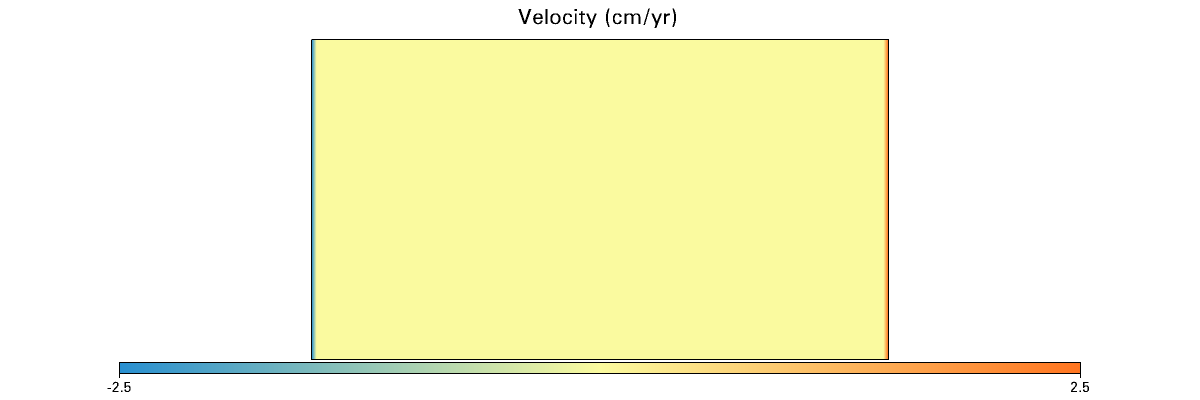

In [25]:
Fig = glucifer.Figure(figsize=(1200,400), title="Velocity (cm/yr)", quality=2)
Fig.Surface(Model.mesh, Model.velocityField[0])
Fig.show()

# <span style="color:brown"> Verifications - Temperature </span>


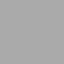

In [26]:
temp_scaling = GEO.Dimensionalize(1., u.degK)
temp_scaling.magnitude


Fig = glucifer.Figure()
Fig.Surface(Model.mesh, temp_scaling.magnitude*Model.temperature, cullface=False,opacity=1.)
viewer = Fig.viewer()#resolution=(1200,600))
viewer.window()
viewer.rotatex(0)
viewer.rotatey(-0)
# viewer.window()

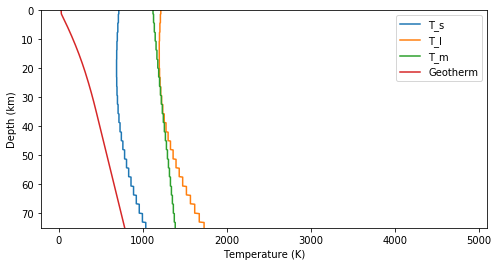

In [27]:
# Solidus

distances, temperature = GEO.extract_profile(Model.temperature, line = [(192.* u.kilometer, 0.), (192.* u.kilometer, Model.bottom)])
distances, pressure = GEO.extract_profile(Model.pressureField, line = [(192.* u.kilometer, 0.), (192.* u.kilometer, Model.bottom)])

solidii = GEO.SolidusRegistry()
crust_solidus = solidii.Crustal_Solidus
mantle_solidus = solidii.Mantle_Solidus


#T_s = crust_solidus.temperature(Model.pressureField)
#T_m = mantle_solidus.temperature(Model.pressureField)
#T_l = crust_liquidus.temperature(Model.pressureField)
T_s = crust_solidus.temperature(pressure)
T_m = mantle_solidus.temperature(pressure)
T_l = crust_liquidus.temperature(pressure)
depths = distances

#import pylab as plt
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(8,4))
plt.plot(GEO.Dimensionalize(T_s, u.degC),GEO.dimensionalise(depths, u.kilometer), label="T_s")
plt.plot(GEO.Dimensionalize(T_l, u.degC),GEO.dimensionalise(depths, u.kilometer), label="T_l")
plt.plot(GEO.Dimensionalize(T_m, u.degC),GEO.dimensionalise(depths, u.kilometer), label="T_m")
plt.plot(GEO.Dimensionalize(temperature, u.degC),GEO.dimensionalise(depths, u.kilometer), label="Geotherm")
plt.xlabel("Temperature (K)")
plt.ylabel("Depth (km)")
plt.legend()
plt.ylim(75, 0)
plt.show()

In [28]:
resolution[0], resolution[1]

(128, 64)

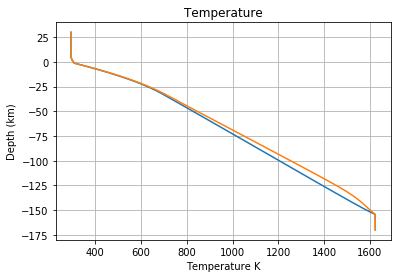

In [29]:
MyTemperatureField=(Model.temperature.data[:] * GEO.Dimensionalize(1.0, u.degK)).magnitude 

TemperatureData=np.asarray(MyTemperatureField)
TemperatureDataShaped=TemperatureData.reshape(resolution[1]+1,resolution[0]+1)

#Two profiles located at the left walls and the middle.
plt.plot(TemperatureDataShaped[:,0], np.linspace(Model.bottom,Model.top,resolution[1]+1))
plt.plot(TemperatureDataShaped[:, 60], np.linspace(Model.bottom,Model.top,resolution[1]+1))

## plt.yticks([-700,-300,-150,-40,0,68])
## plt.xticks([20, 550.0, 1350])
plt.grid()
#plt.xscale('log')
plt.xlabel('Temperature K')
plt.ylabel('Depth (km)')
plt.title('Temperature')
plt.show()

In [30]:
mohoT = Model.temperature.evaluate(moho_tracers)[:,0].mean() # attention ici le fait que ton material ne soit pas uniform joue bcp

print("Moho Temperature at -40 km = ", GEO.dimensionalise(mohoT, u.degC)) 
TemperatureDataShaped[:, 60][-25]

Moho Temperature at -40 km =  488.66177491724295 degC


804.31183617257113

# <span style="color:brown"> Verifications - Viscosity </span>

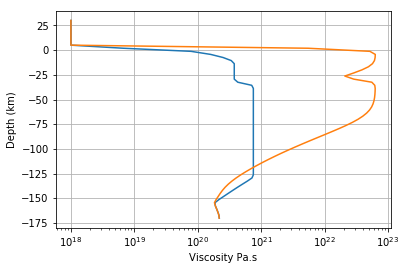

In [31]:
MyViscosityField=(Model.projViscosityField.data[:] * GEO.dimensionalise(1.0, u.pascal * u.second)).magnitude 

ViscosityData=np.asarray(MyViscosityField)
#ViscosityDataShaped=ViscosityData.reshape(81,321)
ViscosityDataShaped=ViscosityData.reshape(resolution[1]+1,resolution[0]+1)

#Two profiles located at the left walls and the middle.
plt.plot(ViscosityDataShaped[:,0], np.linspace(Model.bottom,Model.top,resolution[1]+1))
plt.plot(ViscosityDataShaped[:,60], np.linspace(Model.bottom,Model.top,resolution[1]+1))



## plt.yticks([-700,-300,-150,-40,0,68])
## plt.xticks([20, 550.0, 1350])
plt.grid()
plt.xscale('log')
plt.xlabel('Viscosity Pa.s')
plt.ylabel('Depth (km)')
## plt.title('Viscosity')
plt.show()

# <span style="color:brown"> Verifications - Stress </span>


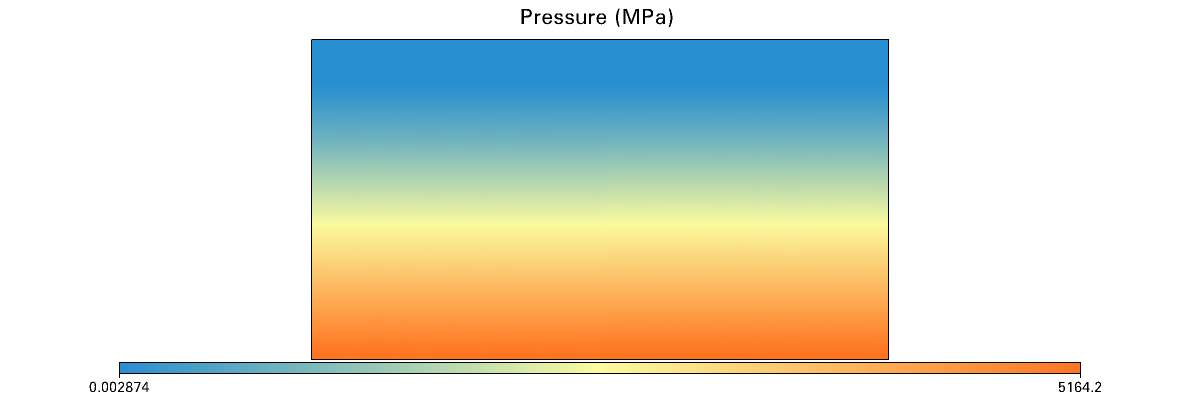

In [32]:
Fig = glucifer.Figure(figsize=(1200,400), title="Pressure (MPa)", quality=2)
Fig.Surface(Model.mesh, GEO.dimensionalise(Model.pressureField, u.megapascal), fn_size=2.0)
Fig.show()

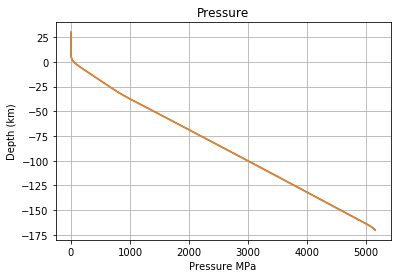

In [33]:
MyPressureField=(Model.pressureField.data[:] * GEO.dimensionalise(1.0, u.megapascal)).magnitude 

PressureData=np.asarray(MyPressureField)
#ViscosityDataShaped=ViscosityData.reshape(81,321)
PressureDataShaped=PressureData.reshape(resolution[1],resolution[0])

#Two profiles located at the left walls and the middle.
plt.plot(PressureDataShaped[:,0], np.linspace(Model.bottom,Model.top,resolution[1]))
plt.plot(PressureDataShaped[:,60], np.linspace(Model.bottom,Model.top,resolution[1]))

## plt.yticks([-700,-300,-150,-40,0,68])
## plt.xticks([20, 550.0, 1350])
plt.grid()
#plt.xscale('log')
plt.xlabel('Pressure MPa')
plt.ylabel('Depth (km)')
plt.title('Pressure')
plt.show()

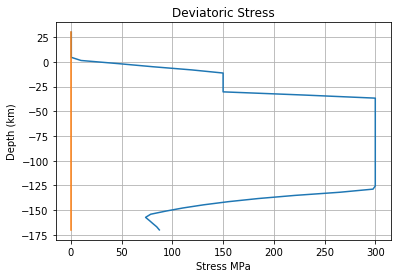

In [34]:
MyStressField=(Model.projStressField.data[:] * GEO.dimensionalise(1.0, u.megapascal)).magnitude 

StressData=np.asarray(MyStressField)
#StressDataShaped=StressData.reshape(120,480)
StressDataShaped=StressData.reshape(resolution[1],resolution[0])

#Two profiles located at the left walls and the middle.

plt.plot(StressDataShaped[:,0], np.linspace(Model.bottom,Model.top,resolution[1]))
plt.plot(StressDataShaped[:,60], np.linspace(Model.bottom,Model.top,resolution[1]))


## plt.yticks([-700,-300,-150,-40,0,68])
## plt.xticks([20, 550.0, 1350])
plt.grid()
plt.xlabel('Stress MPa')
plt.ylabel('Depth (km)')
plt.title('Deviatoric Stress')
plt.show()

## Solver, Model init

In [35]:
GEO.rcParams["default.outputs"].append("projMeltField")
GEO.rcParams["default.outputs"].append("projStressTensor")
GEO.rcParams["default.outputs"].append("projSurfaceProcess")

solver = Model.solver

# Decide whether to use mumps or multigrid
if resolution[0] * resolution[1] < 1e6:
    print("Using mumps")
    solver.set_inner_method("mumps")
else:
    print("Using multigrid with coarse mumps")
    #solver.options.mg.levels = 4
    solver.options.A11.mg_coarse_pc_factor_mat_solver_package = "mumps"
    solver.options.A11.mg_coarse_pc_type = "lu"
    solver.options.A11.mg_coarse_ksp_type = "preonly"
    #solver.options.A11.mg_coarse_ksp_view = ""
    
    

GEO.rcParams["initial.nonlinear.tolerance"] = 1e-3
GEO.rcParams["nonlinear.tolerance"] =         5e-3  # 5e-4
#GEO.rcParams["nonlinear.tolerance"] =         1e-3
GEO.rcParams["nonlinear.min.iterations"] = 1
GEO.rcParams["nonlinear.max.iterations"] = 100
GEO.rcParams["CFL"] = 0.8
#GEO.rcParams["CFL"] = 0.5

GEO.rcParams["advection.diffusion.method"] = "SLCN"
GEO.rcParams["shear.heating"] = True
GEO.rcParams["surface.pressure.normalization"] = True  # Make sure the top of the model is approximately 0 Pa

GEO.rcParams["swarm.particles.per.cell.2D"] = 60
GEO.rcParams["popcontrol.split.threshold"] = 0.95
GEO.rcParams["popcontrol.max.splits"] = 100
GEO.rcParams["popcontrol.particles.per.cell.2D"] = 60

solver.options.A11.ksp_rtol=1e-8
solver.options.A11.ksp_set_min_it_converge = 10
solver.options.A11.use_previous_guess = True
solver.options.scr.ksp_rtol=1e-6
solver.options.scr.use_previous_guess = True
solver.options.scr.ksp_set_min_it_converge = 10
solver.options.scr.ksp_type = "cg"

#solver.options.main.help = ""
solver.options.main.remove_constant_pressure_null_space=True
#solver.options.main.Q22_pc_type = "uwscale"
solver.set_penalty(0)
# Penalty method with mult grid (mg)
#solver.set_penalty(1.0)

Using mumps


In [36]:
GEO.nd(Model.time)

0.0

In [37]:
Filename = 'gregoire-rheo2.ipynb' #The file name of this python notebook goes here.
import shutil
shutil.copy2(Filename, Model.outputDir) #Copies Filename into the model output directory

'outputs2'

In [ ]:
Model.run_for(50.0 * u.megayear, checkpoint_interval=0.01*u.megayear)

Running with UWGeodynamics version 2.8.1-dev-efa530e(development)
Options:  -ksp_k2_type NULL -Q22_pc_type gkgdiag -remove_constant_pressure_null_space True -change_backsolve False -change_A11rhspresolve False -restore_K False -ksp_type bsscr -rescale_equations False -pc_type none -A11_pc_factor_mat_solver_type mumps -A11_ksp_set_min_it_converge 10 -A11_ksp_type preonly -A11_use_previous_guess True -A11_pc_type lu -A11_ksp_rtol 1e-08 -scr_ksp_set_min_it_converge 10 -scr_ksp_type cg -scr_use_previous_guess True -scr_ksp_rtol 1e-06 -A11_mg_active False


/usr/local/underworld2/lib/underworld/systems/_advectiondiffusion.py:80: UserWarning: 'phiDotField' doesn't influence the 'SLCN' method. It's only required for the 'SUPG' method
  " It's only required for the 'SUPG' method")


Step:     1 Model Time: 6666.7 year dt: 6666.7 year (2020-03-16 01:05:28)
Step:     2 Model Time: 10000.0 year dt: 3333.3 year (2020-03-16 01:11:34)
Step:     3 Model Time: 16666.7 year dt: 6666.7 year (2020-03-16 01:14:02)
Step:     4 Model Time: 20000.0 year dt: 3333.3 year (2020-03-16 01:20:18)
Step:     5 Model Time: 26666.7 year dt: 6666.7 year (2020-03-16 01:22:45)
Step:     6 Model Time: 30000.0 year dt: 3333.3 year (2020-03-16 01:29:08)
Step:     7 Model Time: 36666.7 year dt: 6666.7 year (2020-03-16 01:31:41)
Step:     8 Model Time: 40000.0 year dt: 3333.3 year (2020-03-16 01:38:00)
Step:     9 Model Time: 46666.7 year dt: 6666.7 year (2020-03-16 01:40:44)
Step:    10 Model Time: 50000.0 year dt: 3333.3 year (2020-03-16 01:47:04)
Step:    11 Model Time: 56666.7 year dt: 6666.7 year (2020-03-16 01:49:26)
Step:    12 Model Time: 60000.0 year dt: 3333.3 year (2020-03-16 01:55:39)
Step:    13 Model Time: 66666.7 year dt: 6666.7 year (2020-03-16 01:58:04)
Step:    14 Model Time: 70

Step:   110 Model Time: 505293.0 year dt: 5293.0 year (2020-03-16 09:25:50)
Step:   111 Model Time: 510000.0 year dt: 4707.0 year (2020-03-16 09:32:41)
Step:   112 Model Time: 515633.8 year dt: 5633.8 year (2020-03-16 09:35:30)
Step:   113 Model Time: 520000.0 year dt: 4366.2 year (2020-03-16 09:41:40)
Step:   114 Model Time: 524511.4 year dt: 4511.4 year (2020-03-16 09:45:14)
Step:   115 Model Time: 527698.5 year dt: 3187.1 year (2020-03-16 09:48:49)
Step:   116 Model Time: 530000.0 year dt: 2301.5 year (2020-03-16 09:55:13)
Step:   117 Model Time: 533754.9 year dt: 3754.9 year (2020-03-16 09:57:44)
Step:   118 Model Time: 537538.2 year dt: 3783.2 year (2020-03-16 10:00:11)
Step:   119 Model Time: 540000.0 year dt: 2461.8 year (2020-03-16 10:06:48)
Step:   120 Model Time: 543036.7 year dt: 3036.7 year (2020-03-16 10:09:49)
Step:   121 Model Time: 547072.2 year dt: 4035.5 year (2020-03-16 10:13:10)
Step:   122 Model Time: 550000.0 year dt: 2927.8 year (2020-03-16 10:20:13)
Step:   123 

Step:   218 Model Time: 995017.5 year dt: 5017.5 year (2020-03-16 18:04:39)
Step:   219 Model Time: 1.0 megayear dt: 4982.5 year (2020-03-16 18:11:15)
Step:   220 Model Time: 1.0 megayear dt: 4404.3 year (2020-03-16 18:16:12)
Step:   221 Model Time: 1.0 megayear dt: 5595.7 year (2020-03-16 18:23:07)
Step:   222 Model Time: 1.0 megayear dt: 4821.8 year (2020-03-16 18:26:56)
Step:   223 Model Time: 1.0 megayear dt: 5178.2 year (2020-03-16 18:33:34)
Step:   224 Model Time: 1.0 megayear dt: 6666.7 year (2020-03-16 18:36:41)
Step:   225 Model Time: 1.0 megayear dt: 3333.3 year (2020-03-16 18:43:37)
Step:   226 Model Time: 1.0 megayear dt: 6666.7 year (2020-03-16 18:46:16)
Step:   227 Model Time: 1.0 megayear dt: 3333.3 year (2020-03-16 18:52:22)
Step:   228 Model Time: 1.0 megayear dt: 6666.7 year (2020-03-16 18:56:23)
Step:   229 Model Time: 1.0 megayear dt: 3333.3 year (2020-03-16 19:03:35)
Step:   230 Model Time: 1.1 megayear dt: 6666.7 year (2020-03-16 19:06:18)
Step:   231 Model Time: 